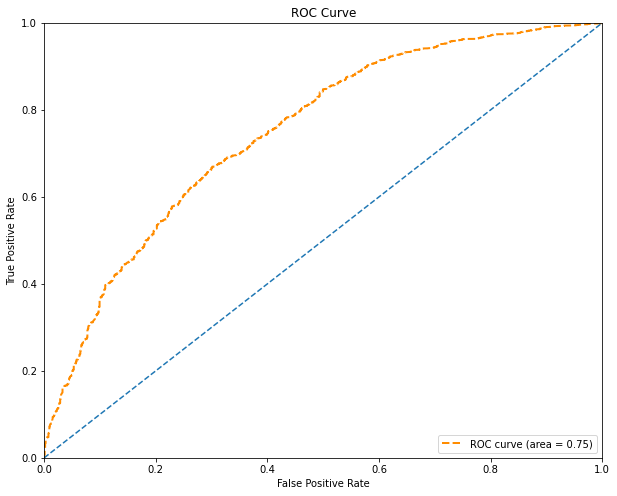

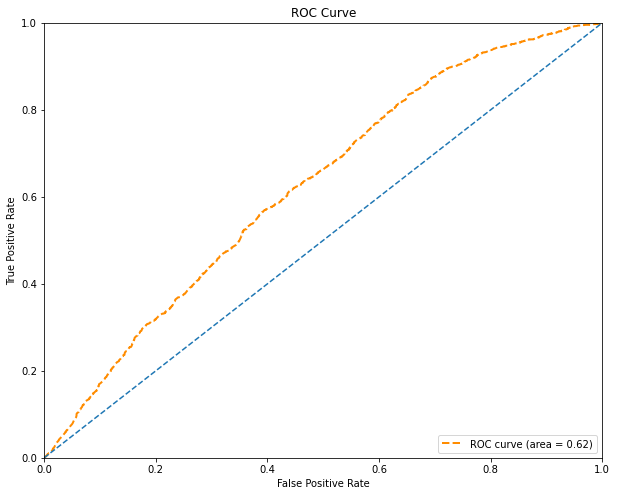

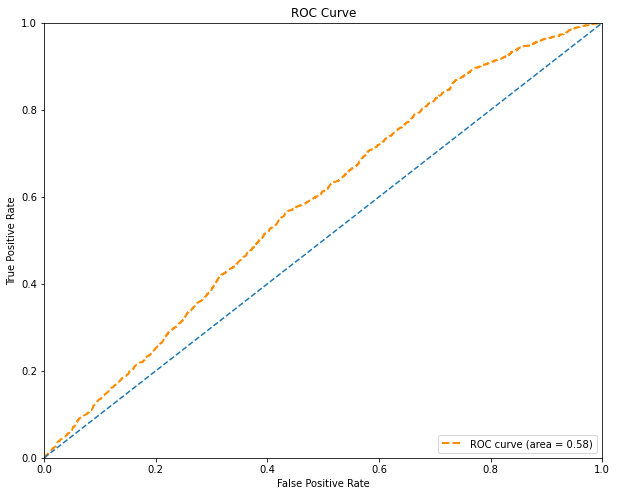

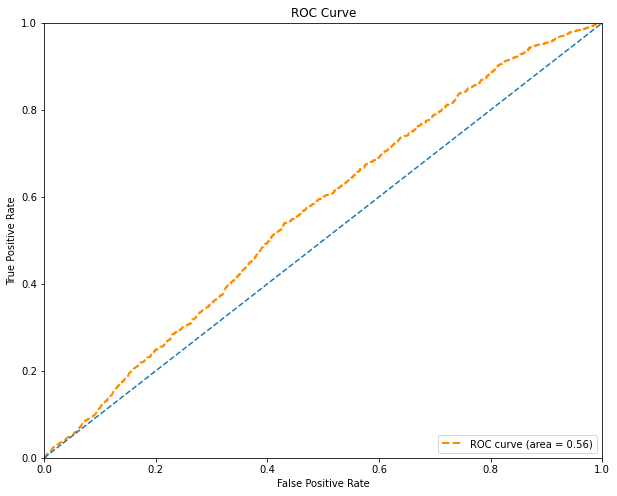

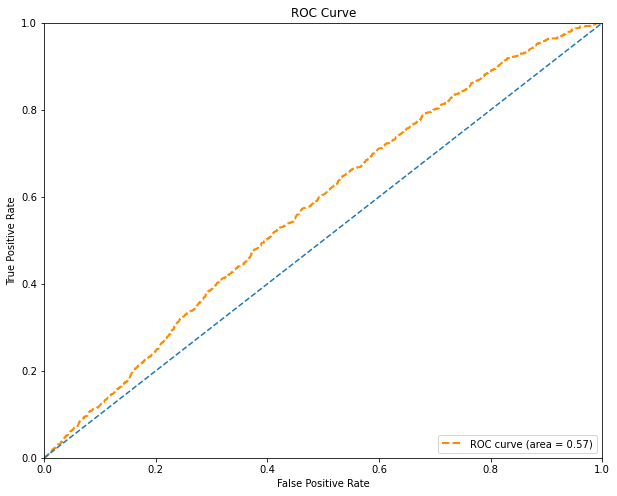

In [4]:
import pandas as pd
import random 

import woeBinningPandas
import math
import warnings
import copy

from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

#load data
data = pd.read_csv('./Data/hmeq.csv', header = 0, sep = ',')
data_len = len(data)
#Thêm một cột class_risk để đánh giá phân loại cuối cùng
data['class_risk'] = data['LOAN']
for i in range(data_len):
    if data['BAD'][i]==1:
        data['class_risk'][i]=1
    else:
        data['class_risk'][i] = random.randrange(2,6)


###Tiền xử lý dữ liệu
##Dữ liệu bị thiếu
#numeric variable thay bằng mean
columns_num = data.select_dtypes(['float', 'int']).columns
data[columns_num] = data[columns_num].apply(lambda x: x.fillna(x.mean()), axis=0)

#category variable thay bằng MissingVal
columns_obj = data.select_dtypes(['object']).columns
data[columns_obj] = data[columns_obj].apply(lambda x: x.fillna('MissingVal'), axis=0)

###Bước 1: WOE và logistic regression
##Biến đổi dữ liệu thành biểu diễn dưới dạng WOE
#Tính WOE cho từng bin
WOE_dict=dict()
bins = {'LOAN', 'MORTDUE', 'VALUE', 'REASON', 'JOB', 'YOJ', 'DEROG', 'DELINQ', 'CLAGE', 'NINQ', 'CLNO', 'DEBTINC'}
nbins = {'LOAN', 'MORTDUE', 'VALUE', 'YOJ', 'DEROG', 'DELINQ', 'CLAGE', 'NINQ', 'CLNO', 'DEBTINC'}
cbins = {'REASON', 'JOB'}
for col in bins:
  df_summary = woeBinningPandas.woe_binning(data, 'BAD', col, 0.1, 0.05, 0, 50, 'bad')
  WOE_dict[col] = df_summary
  
#Thay đổi toàn bộ dữ liệu thành WOE tương ứng
for i in range(data_len):
    for col in nbins:
        for j in range(0,WOE_dict[col].cutpoints_final.count()-1):
            if (data[i:i+1][col][i] > WOE_dict[col].cutpoints_final[j]):
                if (data[i:i+1][col][i] <= WOE_dict[col].cutpoints_final[j+1]):
                    data[i:i+1][col][i] = WOE_dict[col].woe[j]
    for col in cbins:
        for j in range(0,WOE_dict[col].Group_1.count()):
            if (data[i:i+1][col][i] == WOE_dict[col].Group_1[j]):
                data[i:i+1][col][i] = WOE_dict[col].woe[j]

##Áp dụng logistic regression cho 7 bộ feature được chọn bằng stepwise
data['class_risk_m1'] = data['LOAN']
data['class_risk_m2'] = data['LOAN']
data['class_risk_m3'] = data['LOAN']
data['class_risk_m4'] = data['LOAN']
data['class_risk_m5'] = data['LOAN']
data['class_risk_m6'] = data['LOAN']
data['class_risk_m7'] = data['LOAN']

for i in range(data_len):
    if data['class_risk'][i]>1:
        data['class_risk_m1'][i]=1
    else:
        data['class_risk_m1'][i]=0

for i in range(data_len):
    if data['class_risk'][i]>2:
        data['class_risk_m2'][i]=1
    else:
        data['class_risk_m2'][i]=0

for i in range(data_len):
    if data['class_risk'][i]>3:
        data['class_risk_m3'][i]=1
    else:
        data['class_risk_m3'][i]=0

for i in range(data_len):
    if data['class_risk'][i]>4:
        data['class_risk_m4'][i]=1
    else:
        data['class_risk_m4'][i]=0

for i in range(data_len):
    if data['class_risk'][i]==2:
        data['class_risk_m5'][i]=1
    else:
        data['class_risk_m5'][i]=0

for i in range(data_len):
    if data['class_risk'][i]==3:
        data['class_risk_m6'][i]=1
    else:
        data['class_risk_m6'][i]=0

for i in range(data_len):
    if data['class_risk'][i]==4:
        data['class_risk_m7'][i]=1
    else:
        data['class_risk_m7'][i]=0

##Các bộ thuộc tính được chọn
x_train_m1 = data[['LOAN', 'VALUE', 'JOB', 'DEROG', 'CLAGE', 'NINQ']]
x_train_m2 = data[['LOAN', 'VALUE', 'DEROG', 'CLAGE', 'NINQ']]
x_train_m3 = data[['LOAN', 'VALUE', 'DEROG', 'CLAGE', 'CLNO', 'NINQ']]
x_train_m4 = data[['LOAN', 'MORTDUE', 'VALUE', 'JOB', 'DEROG', 'CLAGE', 'NINQ', 'CLNO']]
x_train_m5 = data[['LOAN', 'VALUE', 'JOB', 'DEROG', 'CLAGE', 'NINQ', 'CLNO']]
x_train_m6 = data[['LOAN', 'MORTDUE', 'VALUE', 'DEROG', 'CLAGE', 'NINQ', 'CLNO']]
x_train_m7 = data[['LOAN', 'VALUE', 'JOB', 'DEROG', 'CLAGE', 'NINQ', 'CLNO', 'DEBTINC']]

#các giá trị output cho từng bộ thuộc tính
y_train_m1 = data['class_risk_m1']
y_train_m2 = data['class_risk_m2']
y_train_m3 = data['class_risk_m3']
y_train_m4 = data['class_risk_m4']
y_train_m5 = data['class_risk_m5']
y_train_m6 = data['class_risk_m6']
y_train_m7 = data['class_risk_m7']

#áp dụng logistic regression
logit_model = LogisticRegression(C=1e10)
#áp dụng cho từng bộ thuộc tính
logit_model.fit(x_train_m1, y_train_m1)
y_pred_prob_train_m1 = logit_model.predict_proba(x_train_m1)[:, 1]

logit_model.fit(x_train_m2, y_train_m2)
y_pred_prob_train_m2 = logit_model.predict_proba(x_train_m2)[:, 1]

logit_model.fit(x_train_m3, y_train_m3)
y_pred_prob_train_m3 = logit_model.predict_proba(x_train_m3)[:, 1]

logit_model.fit(x_train_m4, y_train_m4)
y_pred_prob_train_m4 = logit_model.predict_proba(x_train_m4)[:, 1]

logit_model.fit(x_train_m5, y_train_m5)
y_pred_prob_train_m5 = logit_model.predict_proba(x_train_m5)[:, 1]

logit_model.fit(x_train_m6, y_train_m6)
y_pred_prob_train_m6 = logit_model.predict_proba(x_train_m6)[:, 1]

logit_model.fit(x_train_m7, y_train_m7)
y_pred_prob_train_m7 = logit_model.predict_proba(x_train_m7)[:, 1]

##Vẽ đường cong ROC cho các bộ thuộc tính
def _plot_roc_curve(fpr, tpr, thres, auc):
    plt.figure(figsize = (10, 8))
    plt.plot(fpr, tpr, 'b-', color='darkorange', lw=2, linestyle='--', label='ROC curve (area = %0.2f)'%auc)
    plt.plot([0, 1], [0, 1], '--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.title('ROC Curve')

fpr1, tpr1, thres1 = roc_curve(y_train_m1, y_pred_prob_train_m1)
roc_auc1 = auc(fpr1, tpr1)
_plot_roc_curve(fpr1, tpr1, thres1, roc_auc1)

fpr2, tpr2, thres2 = roc_curve(y_train_m2, y_pred_prob_train_m2)
roc_auc2 = auc(fpr2, tpr2)
_plot_roc_curve(fpr2, tpr2, thres2, roc_auc2)

fpr3, tpr3, thres3 = roc_curve(y_train_m3, y_pred_prob_train_m3)
roc_auc3 = auc(fpr3, tpr3)
_plot_roc_curve(fpr3, tpr3, thres3, roc_auc3)

fpr4, tpr4, thres4 = roc_curve(y_train_m4, y_pred_prob_train_m4)
roc_auc4 = auc(fpr4, tpr4)
_plot_roc_curve(fpr4, tpr4, thres4, roc_auc4)

fpr5, tpr5, thres5 = roc_curve(y_train_m5, y_pred_prob_train_m5)
roc_auc5 = auc(fpr5, tpr5)
_plot_roc_curve(fpr5, tpr5, thres5, roc_auc5)

fpr6, tpr6, thres6 = roc_curve(y_train_m6, y_pred_prob_train_m6)
roc_auc6 = auc(fpr6, tpr6)

##Lưu output của từng bộ thuộc tính vào data để làm input cho giai đoạn 2
data['m1'] = data['JOB']
for i in range(data_len):
    data['m1'][i] = y_pred_prob_train_m1[i]

data['m2'] = data['JOB']
for i in range(data_len):
    data['m2'][i] = y_pred_prob_train_m2[i]

data['m3'] = data['JOB']
for i in range(data_len):
    data['m3'][i] = y_pred_prob_train_m3[i]

data['m4'] = data['JOB']
for i in range(data_len):
    data['m4'][i] = y_pred_prob_train_m4[i]

data['m5'] = data['JOB']
for i in range(data_len):
    data['m5'][i] = y_pred_prob_train_m5[i]

data['m6'] = data['JOB']
for i in range(data_len):
    data['m6'][i] = y_pred_prob_train_m6[i]

data['m7'] = data['JOB']
for i in range(data_len):
    data['m7'][i] = y_pred_prob_train_m7[i]

data.to_csv('./Data/dataFormat.csv', index=False, header=True)

In [16]:
# Thuộc tính target
labels = data['class_risk']

# tách train test data
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size= 0.2, random_state=42)

# Lưu test data để tính accuracy
X_test.to_csv('./Data/x_test.csv', index=False, header=True)
y_test.to_csv('./Data/y_test.csv', index=False, header=True)

X_train.to_csv('./Data/x_train.csv', index=False, header=True)
y_train.to_csv('./Data/y_train.csv', index=False, header=True)

In [24]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsOneClassifier
from sklearn.metrics import confusion_matrix 

###Bước 2: sử dụng SVM để phân loại cuối cùng
##xác định input và output tiến hành train
X = X_train[['m1', 'm2', 'm3', 'm4', 'm5', 'm6', 'm7']].values
y = X_train['class_risk'].values

##xác định input và output tiến hành test
X_t = X_test[['m1', 'm2', 'm3', 'm4', 'm5', 'm6', 'm7']].values
y_t = X_test['class_risk'].values

##train SVM
clf = OneVsOneClassifier(SVC(kernel='linear', gamma = 2.5, C=100,  decision_function_shape= 'ovo'))
clf.fit(X, y)

#Kết quả của train
predict = clf.predict(X)
score = accuracy_score(predict, y)
print("Tranning :")
print(score)
print(confusion_matrix(y,predict))

#Kết quả của test
predict_test = clf.predict(X_t)
score = accuracy_score(predict_test, y_t)
print("Testing :")
print(score)
print(confusion_matrix(y_t,predict_test))

Tranning :
0.28062080536912754
[[507   0 238  47 132]
 [152   0 351 183 218]
 [194   0 423 195 181]
 [162   0 387 214 199]
 [193   0 398 200 194]]
Testing :
0.2726510067114094
[[132   0  73  19  41]
 [ 51   0  80  38  51]
 [ 47   0  94  49  53]
 [ 42   0  74  46  55]
 [ 32   0 109  53  53]]
